In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model

data_dir = pathlib.Path('s82j8dh4rr-1')

In [2]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Image Count : ', image_count)

Image Count :  3500


In [3]:
img_height = 224
img_width = 224

train_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=0.2, subset='training')

Found 3500 files belonging to 10 classes.
Using 2800 files for training.


In [4]:
val_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=0.1, subset='validation')

Found 3500 files belonging to 10 classes.
Using 350 files for validation.


In [5]:
test_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=0.1, subset='validation')

Found 3500 files belonging to 10 classes.
Using 350 files for validation.


In [6]:
base_model = EfficientNetV2B0(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [8]:
model=Sequential(name='EfficientNetV2B0')
model.add(base_model)
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1280)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 batch_normalization (Batch  (None, 11520)             46080     
 Normalization)                                                  
                                                  

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
checkpoint = ModelCheckpoint(filepath='EfficientNetV2B0-1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [21]:
model.compile(optimizer='adam',
            loss=SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [22]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_data,validation_data=val_data, epochs = 30, batch_size=128, callbacks=[checkpoint], use_multiprocessing=True)

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.7786
Epoch 1: val_accuracy improved from -inf to 0.94571, saving model to EfficientNetV2B0-1.h5


/Users/athena/mlenv/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 129s 1s/step - loss: 0.7014 - accuracy: 0.7786 - val_loss: 0.1825 - val_accuracy: 0.9457
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9525
Epoch 2: val_accuracy improved from 0.94571 to 0.95714, saving model to EfficientNetV2B0-1.h5
88/88 [==============================] - 130s 1s/step - loss: 0.1775 - accuracy: 0.9525 - val_loss: 0.1909 - val_accuracy: 0.9571
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9668
Epoch 3: val_accuracy improved from 0.95714 to 0.98286, saving model to EfficientNetV2B0-1.h5
88/88 [==============================] - 131s 1s/step - loss: 0.1328 - accuracy: 0.9668 - val_loss: 0.0559 - val_accuracy: 0.9829
Epoch 4/30
88/88 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9779
Epoch 4: val_accuracy did not improve from 0.98286
88/88 [==============================] - 132s 1s/step - loss: 0.0924 - accuracy: 0.9779 -

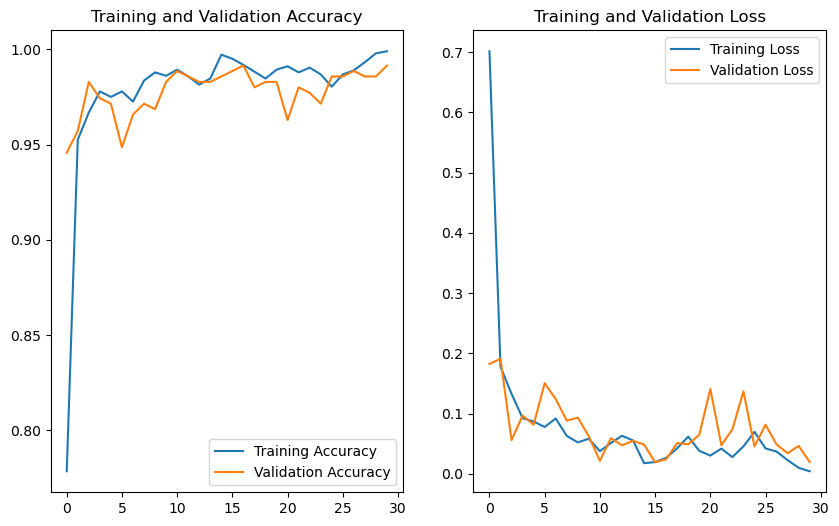

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.evaluate(test_data)

11/11 [==============================] - 4s 320ms/step - loss: 0.0195 - accuracy: 0.9914


[0.019546417519450188, 0.991428554058075]

In [25]:
y_pred = model.predict(test_data)

11/11 [==============================] - 5s 316ms/step


In [26]:
labels = train_data.class_names
def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


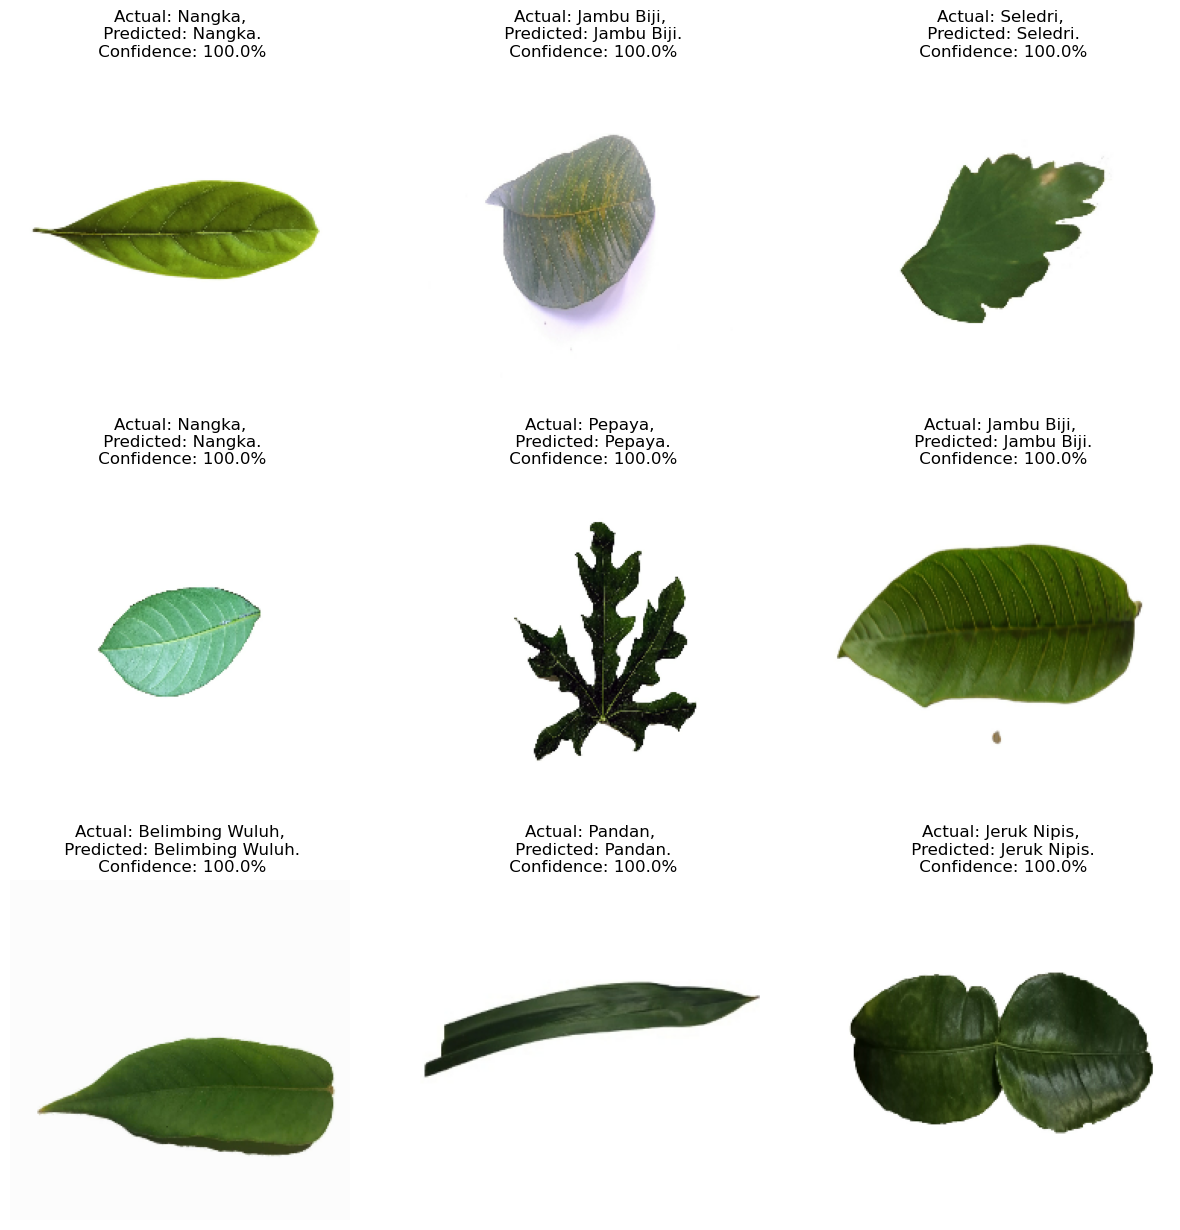

In [42]:
plt.figure(figsize=(15, 15))

for images, lbs in test_data.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence*100}%")
        
        plt.axis("off")

In [76]:
model.save('Model_EfficientNetV2B0-2.h5')

/Users/athena/mlenv/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
